In [1]:
import numpy as np
import matplotlib.pyplot
import mnist
import scipy
import scipy.sparse.linalg
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import pdb

In [2]:
trainX, trainY = mnist.load_mnist("training", None, './MNIST');
testX, testY = mnist.load_mnist("testing", None, './MNIST');
print("MNIST loaded")

MNIST loaded


In [3]:
class logistic:
    
    
    def __init__(self, eta, lamda, thresh, batchSize):
        self.eta = eta;
        self.lamda = lamda;
        self.thresh = thresh;
        self.regularized = True;
        self.lossSet = np.zeros(100000);
        self.testLossSet = np.zeros(100000);
        self.loss01Set = np.zeros(100000);
        self.testLoss01Set = np.zeros(100000);
        self.trainLossSet = np.zeros(100000);
        self.trainLoss01Set = np.zeros(100000);
        self.batchSize = batchSize;
        self.stoch = True;
        
    def load_train(self, trainX, trainY):
        self.trainY1 = trainY;
        s = trainX.shape;
        self.d = s[1] * s[2] + 1;
        self.n = self.d;
        self.N = s[0];
        self.trainX = np.reshape(trainX, (self.N, self.d-1));
        self.trainX = np.asmatrix(np.insert(self.trainX, 0, 1, axis=1));
        self.trainY = np.zeros((self.N, 10),dtype=np.float)
  
        for i in range(0,10):
            temp = np.reshape(np.array(trainY == i, dtype=float), (self.N, 1));
            self.trainY[:,i] = np.asmatrix(np.reshape(temp, self.N))
            
        if self.stoch==False:
            self.probTr = np.asmatrix(np.zeros((self.N, 10),dtype=float))
        else:
            self.probTr = np.asmatrix(np.zeros((self.batchSize, 10),dtype=float))
        self.probTr1 = np.asmatrix(np.zeros((self.N, 10),dtype=float))
        print("Training data loaded...")
        
    def load_test(self, testX, testY):
        self.testY1 = testY;
        self.testN = testX.shape[0];
        self.testX = np.reshape(testX, (self.testN, self.d-1));
        self.testX = np.asmatrix(np.insert(self.testX, 0, 1, axis=1));
        self.testY = np.zeros((self.testN, 10),dtype=np.float)
        self.probTe = np.asmatrix(np.zeros((self.testN, 10),dtype=float))
        
        #pdb.set_trace()
        
        for i in range(0,10):
            temp = np.reshape(np.array(testY == i, dtype=float), (self.testN, 1));
            self.testY[:,i] = np.asmatrix(np.reshape(temp, self.testN))
        print("Testing data loaded...")
        
    def load_batch(self):
        self.Y1 = self.trainY1[self.batchFrom:self.batchTo]
        self.X = self.trainX[self.batchFrom:self.batchTo, :]
        self.Y = self.trainY[self.batchFrom:self.batchTo, :]
        self.batchFrom += self.batchSize
        self.batchTo += self.batchSize
        self.batchFrom = (self.batchFrom - self.N) if self.batchFrom >= self.N else self.batchFrom
        self.batchTo = (self.batchTo - self.N) if self.batchTo > self.N else self.batchTo
    
    def initIteration(self):
        self.weights = np.asmatrix(np.zeros((self.n,10), dtype=float));
        self.iter = 0;
        self.prevLoss = 999999;
        self.weightDist = 99999;
        self.batchFrom = 0;
        self.batchTo = self.batchSize;
        
    def computeProb(self):
        
        temp = self.X * self.weights;
        temp[temp>100] = 100
        
        temp = np.exp(temp);
        sumCol = np.sum(temp, axis=1)
        
        for i in range(0,10):
            self.probTr[:,i] = np.divide(temp[:,i], sumCol) 
        self.sampleLoss = self.Y - self.probTr; 
        
    def computeLoss(self):
        self.loss = -np.sum(np.log(np.sum(np.multiply(self.Y, self.probTr), axis=1) + 0.0000001)) / self.batchSize; 
        self.lossSet[self.iter]=self.loss
        
        self.predLabel = np.argmax(self.probTr, axis=1);
        temp = (np.array(self.predLabel) != np.reshape(self.Y1, (self.batchSize, 1))).astype(float)
        self.loss01Set[self.iter] = np.sum(temp) / self.batchSize;
    
    def computeTestLoss(self):
        temp = self.testX * self.weights;
        temp[temp>100] = 100
        
        temp = np.exp(temp);
        sumCol = np.sum(temp, axis=1)
        
        for i in range(0,10):
            self.probTe[:,i] = np.divide(temp[:,i], sumCol) 
        
        self.testLoss = -np.sum(np.log(np.sum(np.multiply(self.testY, self.probTe), axis=1) + 0.0000001)) / self.testN; 
        self.testLossSet[self.iter]=self.testLoss
        
        self.predLabelTe = np.argmax(self.probTe, axis=1);
        temp = (np.array(self.predLabelTe) != np.reshape(self.testY1, (self.testN, 1))).astype(float)
        self.testLoss01Set[self.iter] = np.sum(temp) / self.testN;
        
    def computeTrainLoss(self):
        temp = self.trainX * self.weights;
        temp[temp>100] = 100
        
        temp = np.exp(temp);
        sumCol = np.sum(temp, axis=1)
        
        for i in range(0,10):
            self.probTr1[:,i] = np.divide(temp[:,i], sumCol) 
        
        self.trainLoss = -np.sum(np.log(np.sum(np.multiply(self.trainY, self.probTr1), axis=1) + 0.0000001)) / self.N; 
        
    def updateWeightsWhole(self):
        deriv = self.Y - self.probTr;
        if self.stoch==True:
            self.weights = self.weights + self.eta * self.X.transpose() * deriv / self.batchSize
            self.weights = self.weights - self.eta * self.weights * self.lamda;
        else:
            self.weights = self.weights + self.eta * self.X.transpose() * deriv / self.N
    
    def distWeight(self, A, B):
        self.weightDist = scipy.linalg.norm(A - B);
        
    
    def assess(self):
        self.computeProb1();
        self.pred = self.prob1 > 0.5;
        self.correct = np.sum(np.int16(self.pred == (self.Y==1)))
        self.overallAccu = np.float(self.correct) / np.float(self.N);
        self.loss01 = sum(abs(self.pred - self.Y)) / self.N
        print('Accuracy : ' + str(self.overallAccu))
        print('0 / 1 loss : ' + str(self.loss01))
    
    def genGaussFeatWeight(self, n):
        self.n = n;
        self.weight = np.asmatrix(np.random.randn(self.d, self.n));
    
    def randGaussFeatConv(self):
        trainX = self.trainX * self.weight;
        testX = self.testX * self.weight;
        
        self.trainX = np.reshape(trainX, (self.N, self.n));
        self.trainX = np.asmatrix(np.insert(self.trainX, 0, 1, axis=1));
        self.testX = np.reshape(testX, (self.testN, self.n));
        self.testX = np.asmatrix(np.insert(self.testX, 0, 1, axis=1));
        
        self.d = self.n;
        self.n = self.n+1;
        print("Feature generation complete....")
        
    def plotLoss(self, labelTrain, labelTest, name):
        red_star = matplotlib.pyplot.plot(np.arange(0, self.iter), model.lossSet[0:self.iter], color="red", hold = True, label=labelTrain, linewidth=2.0)
        blue_star = matplotlib.pyplot.plot(np.arange(0, self.iter), model.testLossSet[0:self.iter], hold = True, color="blue", label=labelTest, linewidth=2.0)
        matplotlib.pyplot.savefig(name, transparent = True)
    
    def plotLoss01(self, labelTrain, labelTest, name):
        red_star = matplotlib.pyplot.plot(np.arange(0, self.iter), model.loss01Set[0:self.iter], color="red", hold = True, label=labelTrain, linewidth=2.0)
        blue_star = matplotlib.pyplot.plot(np.arange(0, self.iter), model.testLoss01Set[0:self.iter], hold = True, color="blue", label=labelTest, linewidth=2.0)
        matplotlib.pyplot.savefig(name, transparent = True)

In [6]:
model = logistic(0.00001, 0.00001, 0.001, 10000);

model.load_train(trainX, trainY);
model.load_test(testX, testY);

model.genGaussFeatWeight(100);
model.randGaussFeatConv();



Training data loaded...
Testing data loaded...
Feature generation complete....


In [7]:
model.initIteration();
model.load_batch();
model.computeProb();
model.computeLoss();
model.computeTestLoss()

aveloss = np.mean(model.lossSet[max(0, model.iter-50) : model.iter+1]);
print ('Iteration 0 : Loss value ' + str(model.loss))

while (aveloss - model.prevLoss>0.5 or model.iter<25000):
#while (model.prevLoss - model.loss > model.thresh or model.iter<10):
    if model.iter==4000:
        model.eta = 0.000001;
    elif model.iter==15000:
        model.eta = 0.0000001;
    model.load_batch();
    
    model.prevLoss = aveloss;
    model.iter = model.iter + 1;
    temp = model.weights.copy();
    
    model.updateWeightsWhole()
    model.computeProb();
    
    model.computeLoss()
    model.computeTestLoss()
    model.distWeight(temp, model.weights)
    aveloss = np.mean(model.lossSet[max(0, model.iter-50) : model.iter+1]);
    if np.floor(np.float(model.iter)/100) * 100 == model.iter:
        print ('Iteration ' + str(model.iter) + ' : Average Loss value ' + str(aveloss))
        print("weight distance : " + str(model.weightDist));
        print("Testing 0/1 loss : " + str(model.testLoss01Set[model.iter]));
        
model.computeTrainLoss()
model.plotLoss('training loss', 'testing loss', 'stochloss.png')
model.plotLoss01('training loss', 'testing loss', 'stochloss01.png')

Iteration 0 : Loss value 2.30258409299
Iteration 100 : Average Loss value 2.22201592146
weight distance : 0.000102865758673
Testing 0/1 loss : 0.383
Iteration 200 : Average Loss value 2.1202476741
weight distance : 0.000104562778341
Testing 0/1 loss : 0.3582
Iteration 300 : Average Loss value 2.02428670466
weight distance : 0.000105110405778
Testing 0/1 loss : 0.34
Iteration 400 : Average Loss value 1.9342188602
weight distance : 0.000101700942072
Testing 0/1 loss : 0.3231
Iteration 500 : Average Loss value 1.84851393025
weight distance : 0.000104404394546
Testing 0/1 loss : 0.3128
Iteration 600 : Average Loss value 1.76776054126
weight distance : 0.000104859595915
Testing 0/1 loss : 0.3013
Iteration 700 : Average Loss value 1.69274768336
weight distance : 0.000101646236531
Testing 0/1 loss : 0.2915
Iteration 800 : Average Loss value 1.62120356383
weight distance : 0.000104607550382
Testing 0/1 loss : 0.2815
Iteration 900 : Average Loss value 1.5541536201
weight distance : 0.0001049066

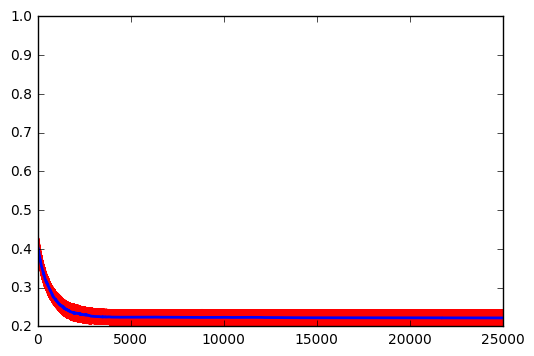

In [8]:
%matplotlib inline 
model.plotLoss01('training loss', 'testing loss', 'neuralLogisticLoss01.png')

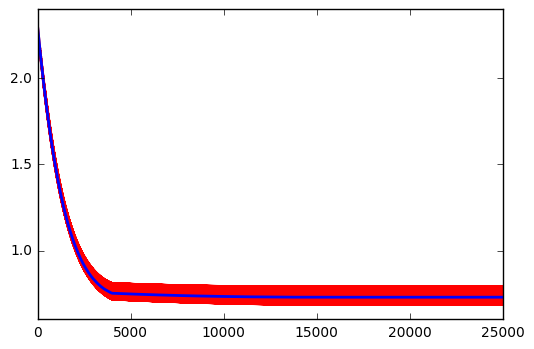

In [9]:
%matplotlib inline 
model.plotLoss('training loss', 'testing loss', 'neuralLogisticLoss.png')

In [13]:
model.testLossSet[model.iter]

0.7291651201773266